# The Clopper-Pearson Binomial Confidence Interval

*Published November 13, 2024*

The goal of this tutorial is to demonstrate the coverage property of the Clopper-Pearson confidence interval. The Clopper-Pearson interval is a confidence interval, as used in inferential statistics, for the success probability $\theta$ in Bernoulli trials. Unlike the Wald interval, which relies on asymptotic behavior, the Clopper-Pearson interval is *exact*, meaning it always achieves a coverage of no less than $1 - \alpha$ for a chosen error rate $\alpha \in (0,1)$. Issues related to confidence intervals based on asymptotic normality are discussed, for example, on [Wikipedia](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Problems_with_using_a_normal_approximation_or_%22Wald_interval%22) or in other sources.

The Clopper-Pearson interval is derived directly from the properties of the binomial distribution, without relying on approximate normality. This guaranteed coverage comes at the cost of generally conservative (i.e., wider) intervals. However, we will not further discuss this limitation. Our focus here is solely on showing that the Clopper-Pearson construction indeed yields a *confidence interval* — specifically, an interval that, under repeated observations of the success count, contains the true success probability in no less than $(1 - \alpha)100\%$ of cases.

We begin our discussion with the definition of the Clopper-Pearson interval (abbreviated as CPI). The definition is interesting because it is implicit. First, however, we need to clarify what we observe and what assumptions we make about how these observations are generated. In our case, this is quite simple: we assume that we are given (the realization of) a random variable $K \sim \mathrm{Binom}(n, \theta)$. Here, $K$ follows a binomial distribution and can be interpreted as the number of successes obtained by conducting $n$ identical and independent Bernoulli trials, where each trial has a probability $\theta$ of success. 

Based on our data, i.e., $K$, we construct a $(1-\alpha)100\%$ confidence interval $(\hat{\theta}_l, \hat{\theta}_u)$, where $\hat{\theta}_{l,u} = \hat{\theta}_{l,u}(K)$, meaning the endpoints of the interval depend on $K$. As noted at the outset, these estimators are defined implicitly. More precisely, we have
\begin{align}
\hat{\theta}_l(K) \equiv \inf \Theta_{\ge}(K) \quad \text{and} \quad \hat{\theta}_u(K) \equiv \sup \Theta_{\le}(K)\text{.}
\end{align}
The two sets that appear are defined as follows:
\begin{align*}
\Theta_{\ge}(K) &\equiv \{ \vartheta \in (0,1) : P\left( X \ge K; \vartheta \right) > \alpha/2 \} \text{,} \\
\Theta_{\le}(K) &\equiv \{ \vartheta \in (0,1) : P\left( X \le K; \vartheta \right) > \alpha/2 \}\text{.}
\end{align*}
For those unfamiliar with statistical terminology, recall that $P(X \ge K; \vartheta)$ is to be read as the probability that a random variable $X \sim \mathrm{Binom}(n, \vartheta)$ is greater than or equal to $K$. In this expression, $K$ is fixed in a certain sense, with all randomness coming from $X$. We interpret $P(X \le K; \vartheta)$ similarly.

The key point is that we select the bounds of the CPI as the smallest or largest success probability under which the events $X \ge K$ or $X \le K$ occur with probability greater than $\alpha/2$. The terms *smallest* and *largest* are a bit informal here, as we are actually dealing with sets that are bounded below or above. Thus, as seen in the definition, it is more precise to refer to the infimum and supremum. 

It is highly illustrative to recognize that the sets we are considering are indeed bounded below or above. This concept will be examined more closely in the following Python code.

**On the nature of $\Theta_{\ge, \le}$**. In defining the CPI, we consider all $\vartheta \in (0, 1)$ that yield probabilities $P\left( X \ge K; \vartheta \right)$ or $P\left( X \le K; \vartheta \right)$ exceeding $\alpha/2$. Here, $K$ is treated as fixed, making these probabilities effectively functions of $\vartheta$. For any given $K$ (or realization $k \in \{0, 1, \dots, n\}$), these two functions can be visualized to explore the values of $\vartheta$ for which the cumulative probabilities exceed $\alpha/2$. The following Python code demonstrates this.

In [1]:
import scipy.stats
import numpy as np

import matplotlib.pyplot as plt

from sklearn.utils import Bunch

In [2]:
cdf = scipy.stats.binom.cdf

For our example, we choose $n=10$, representing a scenario with 10 trials. We assume we observe $k=3$ successes out of these ten trials. For the error probability of our confidence interval, we set $\alpha = 0.05$. Feel free to experiment with these chosen parameters!

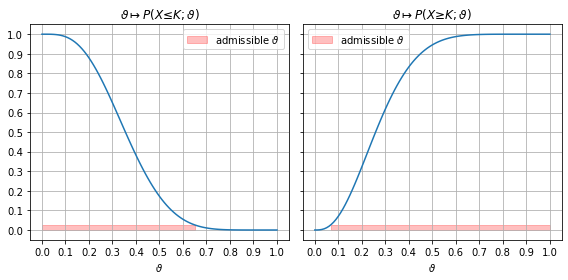

In [3]:
kwargs = Bunch(
    n=10,
    p=np.linspace(0, 1, 101)
)

alpha = 0.05
k_observed = 3

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for idx, (ax, values) in enumerate(zip(
    axs.reshape(-1,),
    [cdf(k_observed, **kwargs), 1 - cdf(k_observed - 1, **kwargs)]
)):
    ax.plot(kwargs.p, values)
    op = {0: "≤", 1: "≥"}.get(idx)
    ax.set_title("$\\vartheta \\mapsto P\left( X" + op + " K; \\vartheta \\right)$")
    ax.set_xlabel("$\\vartheta$")
    ticks = np.linspace(0, 1, 11)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    if idx > 0:
        ax.set_yticklabels([])
    exceeds = values > alpha / 2
    p1, *_, p2 = kwargs.p[exceeds]
    ax.fill_between([p1, p2], [0, 0], [alpha/2, alpha/2], color="red", alpha=0.25, label="admissible $\\vartheta$")
    ax.legend()
    ax.grid(True)

fig.tight_layout()
plt.show()

The semi-transparent red area in the first and second plots corresponds precisely to the set $\Theta_{\le}$ and $\Theta_{\ge}$, respectively. In the first case, the right edge of this area provides the upper bound of the CPI, denoted $\hat{\theta}_u$. In the second case, the left edge gives the lower bound of the CPI, denoted $\hat{\theta}_l$. Since the shape of the curves depends on $K$, the red area - and thus the endpoints of the confidence interval — also depends on $K$, as expected.

**Proving coverage of the CPI**. Returning to our main goal, we aim to show that the constructed interval indeed achieves a coverage of no less than $1 - \alpha$. Mathematically, this means we must have $P\left(\hat{\theta}_l < \theta < \hat{\theta}_u\right) > 1 - \alpha$. Equivalently, we can show that $P\left(\theta \not\in (\hat{\theta}_l, \hat{\theta}_u)\right) \le \alpha$. This is the approach we will follow below.

It is immediately clear that for each $k$, we must have $\hat{\theta}_l(k) \le \hat{\theta}_u(k)$. Suppose there existed a $k$ such that $\hat{\theta}_u(k) < \hat{\theta}_l(k)$. Then we could choose a $\vartheta$ that is greater than $\hat{\theta}_u$ and less than $\hat{\theta}_l$. According to the definition of $\hat{\theta}_u$ as the supremum of $\Theta_{\le}$, it would follow that $P(X \le k; \vartheta) \le \alpha/2$, and similarly, by the definition of $\hat{\theta}_l$ as the infimum of $\Theta_{\ge}$, we would have $P(X \ge k; \vartheta) \le \alpha/2$. Thus, we would get $\alpha \ge P(X \le k; \vartheta) + P(X \ge k; \vartheta) = 1 + P(X = k; \vartheta) > 1$, which is a contradiction.

The desired probability can now be written as
\begin{align}
P\left(\theta \not\in (\hat{\theta}_l, \hat{\theta}_u)\right) &= P\left(\left\{\theta < \hat{\theta}_l(K)\right\} \, \cup \, \left\{\theta > \hat{\theta}_u(K)\right\}\right) \\
&= P\left(\theta < \hat{\theta}_l(K)\right) + P\left(\theta > \hat{\theta}_u(K)\right)\text{,}
\end{align}
where the disjointness of the events follows from the fact that $\left\{ \hat{\theta}_u(K) < \theta < \hat{\theta}_l(K)\right\} = \emptyset$.

As used above, the fact that $\theta < \hat{\theta}_l(K)$ implies that $F(K) \le \alpha / 2$, where $F$ now denotes the cumulative probability $P\left(X \le K; \theta\right)$ for the true parameter value $\theta$. Similarly, $\theta > \hat{\theta}_u(K)$ implies that $1 - F(K-1) \le \alpha / 2$. This allows us to bound the desired probability from above as
\begin{align}
P\left(\theta \not\in (\hat{\theta}_l, \hat{\theta}_u)\right) \le P\left( F(K-1) \ge 1 - \alpha/2\right) + P\left( F(K) \le \alpha / 2 \right)\text{.}
\end{align}
At this point, a straightforward approach would be to use the inverse CDF $F^{-1}$ in both events to immediately obtain the desired lower bound. However, due to the discrete nature of the binomial distribution, this step requires a more careful approach. To proceed, we introduce two functions, $k_{\mathrm{min}}$ and $k_{\mathrm{max}}$, which can be understood as the lower and upper inverse CDFs for binomially distributed random variables $\mathrm{Binom}(n, \theta)$. For each $q \in (0, 1)$, they are defined as
\begin{align}
k_{\mathrm{min}}(q) &\equiv \min \{ k \in \{0, 1, ..., n\} : F(k) \ge q \}\text{,} \\
k_{\mathrm{max}}(q) &\equiv \max \{ k \in \{0, 1, ..., n\} : F(k) \le q \}\text{.}
\end{align}
Clearly,
\begin{align}
&F(k) \ge q \implies k \ge k_{\mathrm{min}}(q)\text{,} \\
&F(k) \le q \implies k \le k_{\mathrm{max}}(q)
\end{align}
for every $k$. This allows us to further bound the desired probability. We now have
\begin{align}
P\left(\theta \not\in (\hat{\theta}_l, \hat{\theta}_u)\right) &\le
P\left( K-1 \ge k_{\mathrm{min}}\left(1-\frac{\alpha}{2}\right)\right)
+P\left( K \le k_{\mathrm{max}}\left( \frac{\alpha}{2}\right)\right) \\
&= \left[ 1 - P\left( K \le k_{\mathrm{min}}\left( 1 - \frac{\alpha}{2}\right)\right)\right] + P\left( K \le k_{\mathrm{max}}\left( \frac{\alpha}{2}\right)\right) \\
&\le \left[ 1 - \left( 1 - \frac{\alpha}{2}\right)\right] + \frac{\alpha}{2} = \alpha\text{,}
\end{align}
where we have used the defining properties of $k_{\mathrm{min}}$ and $k_{\mathrm{max}}$.$\blacksquare$

**Numerical examples**. Finally, we provide a straightforward Python implementation of the CPI and examine the intervals generated in a numerical example when following the Clopper-Pearson method.

In [4]:
def simulate_cpi(num_trials: int, alpha: float = 0.05):
    thetas = np.linspace(0, 1, 501)
    ks = np.arange(num_trials+1)
    cum_le = cdf(
        k=ks.reshape(-1, 1),
        n=num_trials,
        p=thetas.reshape(1, -1)
    )
    cum_ge = 1 - cdf(
        k=ks.reshape(-1, 1) - 1,
        n=num_trials,
        p=thetas.reshape(1, -1)
    )
    admissible_le = cum_le > alpha / 2
    admissible_ge = cum_ge > alpha / 2
    lower = (admissible_ge * thetas.reshape(1, -1) + (1 - admissible_ge) * (1 + 1e-4)).min(axis=-1)
    upper = (admissible_le * thetas.reshape(1, -1)).max(axis=-1)
    return Bunch(
        observed=ks,
        lower=lower,
        upper=upper
    )

The function `simulate_cpi` provides the endpoints of the Clopper-Pearson interval for each possible observation $k = 0, \dots, n$, where $n$, the number of trials, is passed to the function as the parameter `num_trials` (along with the error probability `alpha`). Here, we choose $n=10$, as before. The resulting dictionary includes a `lower` field containing a NumPy array of length $n+1$, which stores the lower endpoints of each interval. Similarly, `upper` contains the $n+1$ upper endpoints. The `observed` field stores the assumed number of observed successes for each entry. We visualize the simulation results by displaying the intervals as line segments for ascending $k$ values, from bottom to top.

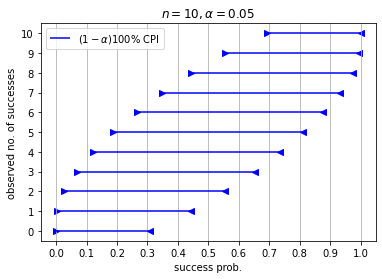

In [5]:
kwargs = Bunch(num_trials=10, alpha=0.05)

def title() -> str:
    return "$n="+str(kwargs.num_trials)+", \\alpha="+"{:.2f}".format(kwargs.alpha)+"$"

res = simulate_cpi(**kwargs)
fig, ax = plt.subplots()
ax.scatter(res.lower, res.observed, marker=">", color="blue")
ax.scatter(res.upper, res.observed, marker="<", color="blue")
ax.hlines(
    xmin=res.lower,
    xmax=res.upper,
    y=res.observed,
    color="blue",
    label="$(1-\\alpha)100\%$ CPI"
)
ax.set_yticks(res.observed)
ax.set_xticks(np.linspace(0, 1, 11))
ax.grid(axis="x")
ax.set_ylabel("observed no. of successes")
ax.set_xlabel("success prob.")
ax.set_title(title())
ax.legend()
plt.show()

As can be seen, the width of the intervals depends on the observed value $k$. The CPI is widest for $k=5$ observed successes, as shown more clearly in the following figure.

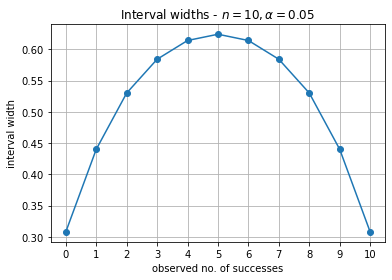

In [6]:
fig, ax = plt.subplots()
ax.plot(res.observed, res.upper - res.lower, marker="o")
ax.set_xticks(res.observed)
ax.grid(True)
ax.set_xlabel("observed no. of successes")
ax.set_ylabel("interval width")
ax.set_title(f"Interval widths - {title()}")
plt.show()